In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch-env/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/pytorch-env/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/homebrew/Caskroom/miniforge/base/envs/pytorch-env/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/pytorch-env/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/pytorch-env/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/pytorch-env/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/pytorch-env/bin/../lib/libjpeg.9.dylib' (no su

In [2]:
# MNIST train 데이터 (60,000개)
mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=ToTensor())

# 20,000개만 사용을 위한 코드
mnist_subset, _ = random_split(mnist_dataset, [20000, 40000])

# train / validation 나누기 (예: 15,000 / 5,000)
train_size = 15000
val_size = len(mnist_subset) - train_size
train_dataset, val_dataset = random_split(mnist_subset, [train_size, val_size])

# test 데이터 (10,000개)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=ToTensor())

In [3]:
# DataLoader (batch 단위로 데이터 공급)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) ######## TODO: batch_size
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

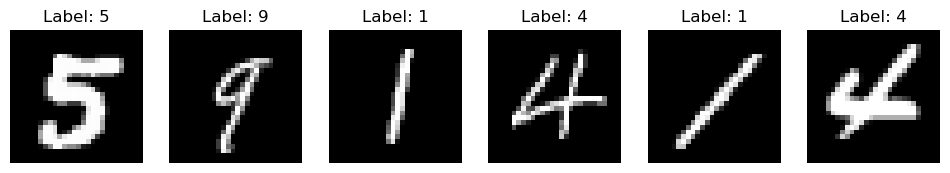

In [4]:
import matplotlib.pyplot as plt

# 데이터 확인: train_loader에서 샘플 몇 개 가져오기
examples = iter(train_loader)
example_data, example_targets = next(examples)

# 6개만 시각화
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    axes[i].imshow(example_data[i][0], cmap="gray")
    axes[i].set_title(f"Label: {example_targets[i].item()}")
    axes[i].axis("off")
plt.show()


In [5]:
class SimpleNN(nn.Module): ######## TODO: number of layers (self.nn)
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.nn1 = nn.Linear(28*28, 64) ######## TODO: number of neurons
        self.nn2 = nn.Linear(64, 10) ######## TODO: number of neurons
        self.activation = nn.Sigmoid() ######## TODO: activation function

    def forward(self, x):
        # print(x.shape) # [64,1,28,28]
        x = x.view(x.shape[0],-1)
        out1 = self.nn1(x)
        out2 = self.activation(out1)
        out3 = self.nn2(out2)
        return out3

In [6]:
model = SimpleNN()
criterion = nn.CrossEntropyLoss()   # 다중분류용 손실함수
optimizer = optim.SGD(model.parameters(), lr=0.001) ######## TODO: learning rate (lr)

In [7]:
num_epochs = 5 ######## TODO: epoch

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()  # 학습 모드
    train_loss, correct = 0, 0
    for images, labels in train_loader:
        outputs = model(images)          # forward
        loss = criterion(outputs, labels) # 손실 계산
        loss.backward()                  # backward
        optimizer.step()                 # 가중치 업데이트
        optimizer.zero_grad()            # gradient 초기화

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss /= len(train_loader)

    # ---- Validation ----
    model.eval()  # 평가 모드
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    val_acc = correct / len(val_dataset)
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/5] Train Loss: 2.3111, Train Acc: 0.1026 | Val Loss: 2.3048, Val Acc: 0.0994
Epoch [2/5] Train Loss: 2.2956, Train Acc: 0.1039 | Val Loss: 2.2922, Val Acc: 0.1122
Epoch [3/5] Train Loss: 2.2860, Train Acc: 0.1477 | Val Loss: 2.2834, Val Acc: 0.2212
Epoch [4/5] Train Loss: 2.2787, Train Acc: 0.2344 | Val Loss: 2.2765, Val Acc: 0.2074
Epoch [5/5] Train Loss: 2.2725, Train Acc: 0.2035 | Val Loss: 2.2702, Val Acc: 0.2102


In [8]:
# ---- Test ----
model.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

test_acc = correct / len(test_dataset)
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 2.2699, Test Accuracy: 0.2283


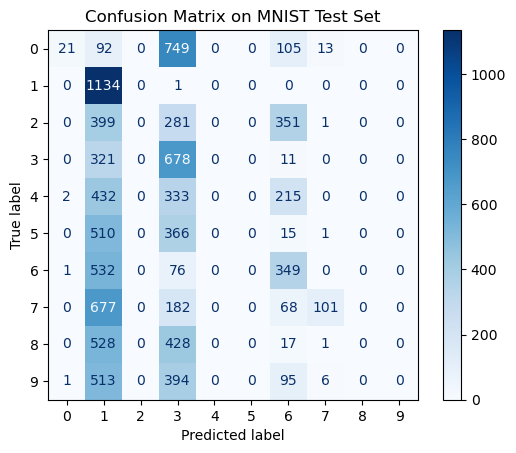

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 모델 예측 vs 실제 라벨 저장
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix 생성
cm = confusion_matrix(all_labels, all_preds)

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix on MNIST Test Set")
plt.show()
